**=== KAGGLE COMPETITION: House Prices - Advanced Regression Techniques ===**

by **Verindra Hernanda Putra**

# Overview

The overral process is : 

- Setup
- About Competition and Dataset
- Cleaning and Preprocessing
- Modeling and Evaluation
- Submission

# Setup

Import common libraries and some QOL

In [1]:
# Imports
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
import warnings
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Basic QOL for documentation purposes
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
start_time = time.time()

In [3]:
# Configurations for the model
class Config:
    INPUT_DIR = "../input/"
    TARGET_COL = "SalePrice"
    N_SPLITS = 10
    SEED = 42
    LGBM_PARAMS = {'objective': 'regression_l1', 'metric': 'rmse', 'boosting_type': 'gbdt','n_estimators': 2000, 'learning_rate': 0.01, 'num_leaves': 31, 'seed': SEED,'n_jobs': -1, 'verbose': -1, 'colsample_bytree': 0.7, 'subsample': 0.7,'reg_alpha': 0.1, 'reg_lambda': 0.1,}
    XGB_PARAMS = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.01,'max_depth': 4, 'subsample': 0.7, 'colsample_bytree': 0.7,'seed': SEED, 'n_jobs': -1, 'n_estimators': 1500}
    CAT_PARAMS = {'iterations': 2000, 'learning_rate': 0.02, 'depth': 6,'loss_function': 'RMSE', 'eval_metric': 'RMSE','random_seed': SEED, 'verbose': 0, 'allow_writing_files': False,}
    LGBM_EARLY_STOPPING_ROUNDS = 100
    CAT_EARLY_STOPPING_ROUNDS = 100

# About Competition and Dataset

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

> Please read the data_description.txt on input folder for more information

In [4]:
# Load Data
train_df = pd.read_csv(f"{Config.INPUT_DIR}/train.csv")
test_df = pd.read_csv(f"{Config.INPUT_DIR}/test.csv")
sample_submission = pd.read_csv(f"{Config.INPUT_DIR}/sample_submission.csv")

In [5]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [6]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [7]:
sample_submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


# Cleaning and Preprocessing

Check the dataset to find the correct action for cleaning and preprocessing the dataset

In [8]:
def generate_data_quality_report(df, stage_name):
    print(f"\n--- Data Quality Report: {stage_name} ---")
    print(f"Dataset Shape: {df.shape}")
    
    # Missing Values
    missing_values = df.isnull().sum()
    missing_cols = missing_values[missing_values > 0]
    if not missing_cols.empty:
        print("\nMissing Values:")
        missing_df = pd.DataFrame({'Count': missing_cols, 'Percentage': (missing_cols / len(df)) * 100})
        print(missing_df.sort_values(by='Count', ascending=False))
    else:
        print("\nNo missing values found.")
        
    # Data Types
    print("\nData Types:")
    print(df.dtypes.value_counts())
    
    print("-"*(30 + len(stage_name)))

In [9]:
generate_data_quality_report(train_df, "Before Cleaning")


--- Data Quality Report: Before Cleaning ---
Dataset Shape: (1460, 81)

Missing Values:
              Count  Percentage
PoolQC         1453   99.520548
MiscFeature    1406   96.301370
Alley          1369   93.767123
Fence          1179   80.753425
MasVnrType      872   59.726027
FireplaceQu     690   47.260274
LotFrontage     259   17.739726
GarageType       81    5.547945
GarageYrBlt      81    5.547945
GarageFinish     81    5.547945
GarageQual       81    5.547945
GarageCond       81    5.547945
BsmtFinType2     38    2.602740
BsmtExposure     38    2.602740
BsmtFinType1     37    2.534247
BsmtCond         37    2.534247
BsmtQual         37    2.534247
MasVnrArea        8    0.547945
Electrical        1    0.068493

Data Types:
object     43
int64      35
float64     3
Name: count, dtype: int64
---------------------------------------------


In [10]:
# Basic EDA to visualize target distribution and outliers
def perform_pre_modeling_eda(df):
    print("\n--- Pre-Modeling EDA ---")
    plt.figure(figsize=(12, 5))
    sns.histplot(df[Config.TARGET_COL], kde=True, bins=50); plt.title('Distribution of SalePrice'); plt.savefig('eda_target_distribution.png'); plt.show()
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=df['GrLivArea'], y=df[Config.TARGET_COL]); plt.title('GrLivArea vs SalePrice'); plt.savefig('eda_outlier_plot.png'); plt.show()


--- Pre-Modeling EDA ---


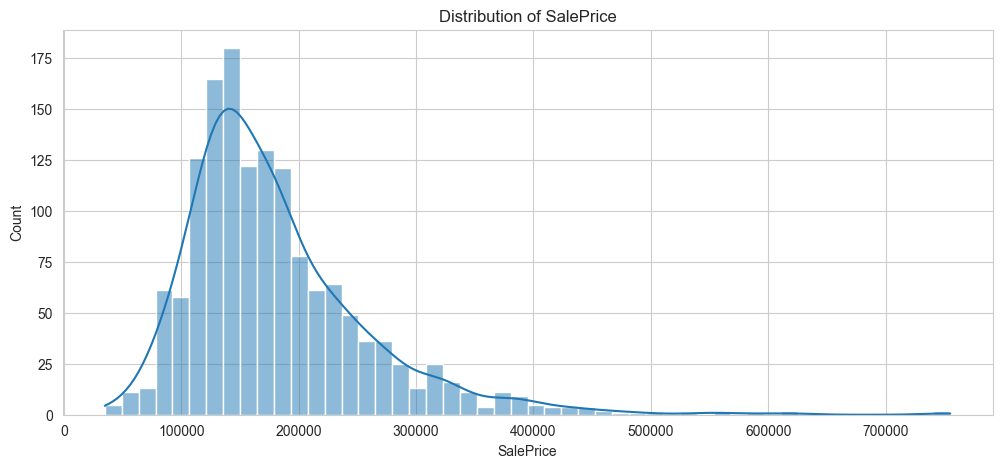

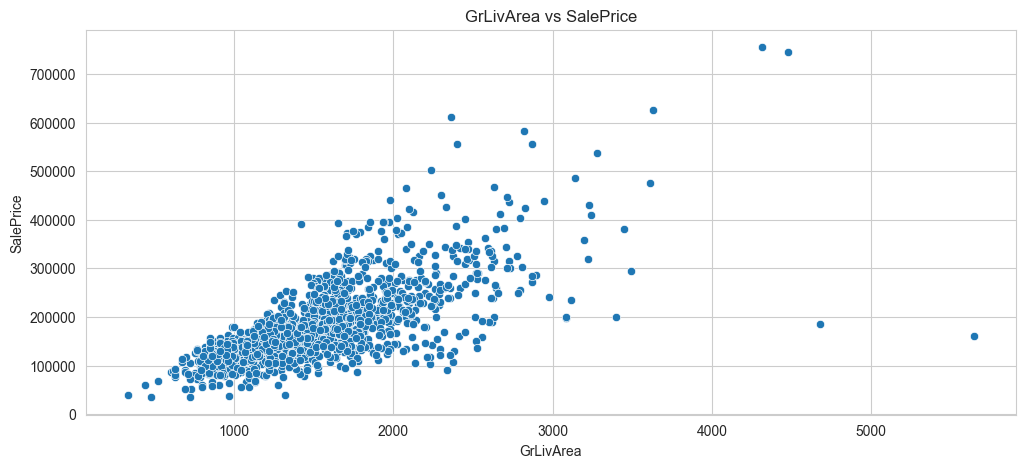

In [11]:
perform_pre_modeling_eda(train_df.copy())

In [12]:
# Display basic information about the dataset such as columns and data types
print("\nDataset Info:")
train_df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64 

In [13]:
# Log Transform Target
y = np.log1p(train_df[Config.TARGET_COL])
train_df = train_df.drop(['Id', Config.TARGET_COL], axis=1)
test_df = test_df.drop('Id', axis=1)

In [14]:
# Data Engineering Function
def create_features(df):
    df['MSSubClass'] = df['MSSubClass'].astype(str)

    na_as_none_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
    
    for col in na_as_none_cols: 
        df[col] = df[col].fillna('None')

    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    for col in df.select_dtypes(include=np.number).columns: 
        df[col] = df[col].fillna(0)

    for col in df.select_dtypes(include='object').columns: 
        df[col] = df[col].fillna(df[col].mode()[0])
    
    quality_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    ordinal_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
    
    for col in ordinal_cols: 
        df[col] = df[col].map(quality_map)

    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

    numeric_feats = df.select_dtypes(include=np.number).columns
    skewed_feats = df[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
    skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]

    for feat in skewed_feats.index:
        if feat != Config.TARGET_COL: df[feat] = np.log1p(df[feat])

    return df

In [15]:
# Feature Engineering
print("\nCreating features on the full training data...")
full_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
full_df_engineered = create_features(full_df)


Creating features on the full training data...


In [16]:
generate_data_quality_report(full_df_engineered, "After Feature Engineering")


--- Data Quality Report: After Feature Engineering ---
Dataset Shape: (2919, 82)

No missing values found.

Data Types:
object     34
float64    34
int64      14
Name: count, dtype: int64
-------------------------------------------------------


# Modelling and Evaluation

Split train and test then setup model for training

In [17]:
# Separate train/test
full_df_engineered = pd.get_dummies(full_df_engineered, drop_first=True)
X = full_df_engineered[:len(train_df)]
X_test = full_df_engineered[len(train_df):]

In [18]:
# --- Level 0 Model Training ---
print("\n--- Starting Level 0 Model Training ---")
kf = KFold(n_splits=Config.N_SPLITS, shuffle=True, random_state=Config.SEED)

oof_lgb = np.zeros(len(X)); test_lgb = np.zeros(len(X_test))
oof_xgb = np.zeros(len(X)); test_xgb = np.zeros(len(X_test))
oof_cat = np.zeros(len(X)); test_cat = np.zeros(len(X_test))

# Align columns to prevent errors
common_cols = list(set(X.columns).intersection(set(X_test.columns)))
X = X[common_cols]
X_test = X_test[common_cols]

# Level 0 Model Training
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"--- FOLD {fold+1}/{Config.N_SPLITS} ---")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    # LGBM
    lgb_model = lgb.LGBMRegressor(**Config.LGBM_PARAMS)
    lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(Config.LGBM_EARLY_STOPPING_ROUNDS, verbose=False)])
    oof_lgb[val_idx] = lgb_model.predict(X_val)
    test_lgb += lgb_model.predict(X_test) / Config.N_SPLITS

    # XGB
    xgb_model = xgb.XGBRegressor(**Config.XGB_PARAMS)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    oof_xgb[val_idx] = xgb_model.predict(X_val)
    test_xgb += xgb_model.predict(X_test) / Config.N_SPLITS

    # CatBoost
    cat_model = cb.CatBoostRegressor(**Config.CAT_PARAMS)
    cat_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=Config.CAT_EARLY_STOPPING_ROUNDS, verbose=False)
    oof_cat[val_idx] = cat_model.predict(X_val)
    test_cat += cat_model.predict(X_test) / Config.N_SPLITS

# --- Evaluate Level 0 Models ---
print("="*50)
print(f"Final OOF RMSE for LGB: {np.sqrt(mean_squared_error(y, oof_lgb)):.5f}, XGB: {np.sqrt(mean_squared_error(y, oof_xgb)):.5f}, CAT: {np.sqrt(mean_squared_error(y, oof_cat)):.5f}")
print("="*50)


--- Starting Level 0 Model Training ---
--- FOLD 1/10 ---
--- FOLD 2/10 ---
--- FOLD 3/10 ---
--- FOLD 4/10 ---
--- FOLD 5/10 ---
--- FOLD 6/10 ---
--- FOLD 7/10 ---
--- FOLD 8/10 ---
--- FOLD 9/10 ---
--- FOLD 10/10 ---
Final OOF RMSE for LGB: 0.12616, XGB: 0.12334, CAT: 0.12151


In [19]:
def perform_post_modeling_analysis(y_true, oof_preds):
    print("\n--- Starting Post-Modeling Performance Analysis ---")
    residuals = y_true - oof_preds
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1); sns.scatterplot(x=y_true, y=oof_preds, alpha=0.5); plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', lw=2, color='red'); plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Predictions vs. Actual')
    plt.subplot(1, 3, 2); sns.scatterplot(x=oof_preds, y=residuals, alpha=0.5); plt.axhline(y=0, color='red', linestyle='--', lw=2); plt.xlabel('Predicted'); plt.ylabel('Residuals'); plt.title('Residuals vs. Predictions')
    plt.subplot(1, 3, 3); sns.histplot(residuals, kde=True, bins=50); plt.xlabel('Residuals'); plt.title('Distribution of Errors')
    plt.tight_layout(); plt.savefig('analysis_performance_plots.png'); plt.show()
    print("--- Post-Modeling Analysis Finished ---")

In [20]:
# --- Level 1 Stacking ---
print("\n--- Starting Level 1 Stacking ---")
train_meta = pd.DataFrame({'lgb': oof_lgb, 'xgb': oof_xgb, 'cat': oof_cat})
test_meta = pd.DataFrame({'lgb': test_lgb, 'xgb': test_xgb, 'cat': test_cat})

print("Training meta-model (RidgeCV)...")
meta_model = RidgeCV(alphas=np.logspace(-4, 2, 20), cv=5)
meta_model.fit(train_meta, y)

final_predictions = meta_model.predict(test_meta)
stacked_oof_preds = meta_model.predict(train_meta)
stacked_oof_rmse = np.sqrt(mean_squared_error(y, stacked_oof_preds))
print(f"Final Stacked OOF RMSE: {stacked_oof_rmse:.5f}")
print("="*50)


--- Starting Level 1 Stacking ---
Training meta-model (RidgeCV)...
Final Stacked OOF RMSE: 0.12024



--- Starting Post-Modeling Performance Analysis ---


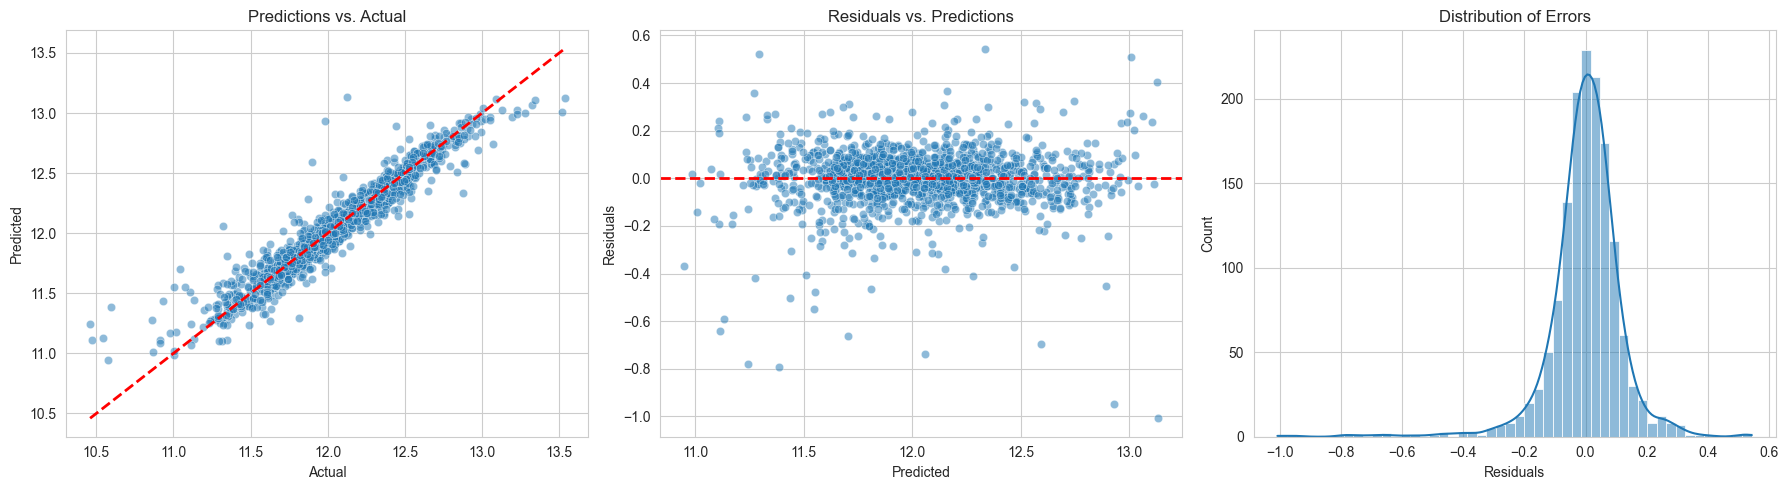

--- Post-Modeling Analysis Finished ---


In [21]:
perform_post_modeling_analysis(y, stacked_oof_preds)

# Submission

Submission the file based on sample submission

In [22]:
# --- Create Submission File ---
print("Creating final submission file...")
final_predictions_exp = np.expm1(final_predictions)

submission = pd.DataFrame({'Id': sample_submission['Id'], 'SalePrice': final_predictions_exp})
submission['SalePrice'] = submission['SalePrice'].clip(lower=0)
submission.to_csv('submission_finale.csv', index=False)

# --- Time Report ---
print("Submission 'submission_finale.csv' created successfully.")
print(f"\nTotal script execution time: {time.time() - start_time:.2f} seconds.")
print("="*80)
print("The Auditable Pipeline is complete. Your training is finished.")

Creating final submission file...
Submission 'submission_finale.csv' created successfully.

Total script execution time: 101.30 seconds.
The Auditable Pipeline is complete. Your training is finished.
